# Exploratory data analysis (EDA) for the string feature (`f_27`)

Even a quick glance at the dataset for the Tabular Playground Series May 2022 shows that one of the features is very different to the others: whereas all the other features are numeric,`f_27` is a string of 10 characters. In this notebook I explore this feature a little to try and gain some insights as to how we might model it and use it for predictions

In [1]:
import itertools as it
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')
summary_stats = train.describe().T

#summary_stats

In [3]:
test = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')
test_summary_stats = test.describe().T

#test_summary_stats

N = train.shape[0] + test.shape[0]

In [4]:
train['f_27'].head()


0    ABABDADBAB
1    ACACCADCEB
2    AAAEABCKAD
3    BDBBAACBCB
4    BDBCBBCHFE
Name: f_27, dtype: object

In [5]:
train['f_27'].value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

The letter 'B' looks pretty common, and there are a few strings that get repeated, the most common being 'BBBBBBCJBC'. Let's look at the distribution of letters:

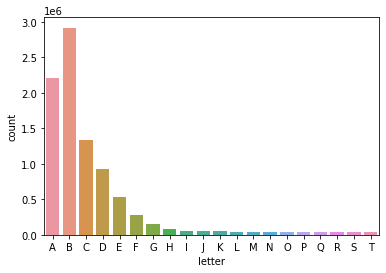

In [6]:
unique_letters = set(())
from collections import Counter
c = Counter()
cps = [Counter() for _ in range(10)]
for i,astr in enumerate(train['f_27']):
   
    letters = [str(x) for x in astr]
    unique_letters.update(letters)
    c.update(letters)
    for i in range(10):
        cps[i].update([letters[i],])
    if i == 10**12:
        break

letter_freqs = pd.DataFrame(c.items())
letter_freqs.columns = ['letter', 'count']
_=sns.barplot(data=letter_freqs.sort_values(by=['letter']), x='letter', y='count')

cps_test = [Counter() for _ in range(10)]
for i,astr in enumerate(test['f_27']):
    
    letters = [str(x) for x in astr]
    for i in range(10):
        cps_test[i].update([letters[i],])
    if i == 10**12:
        break



Yep, 'B' is most common. The distribution of letters looks kind of like a Gamma distribution but with a long tail. Let's look at the distribution of letters in each position and how they relate to the target:

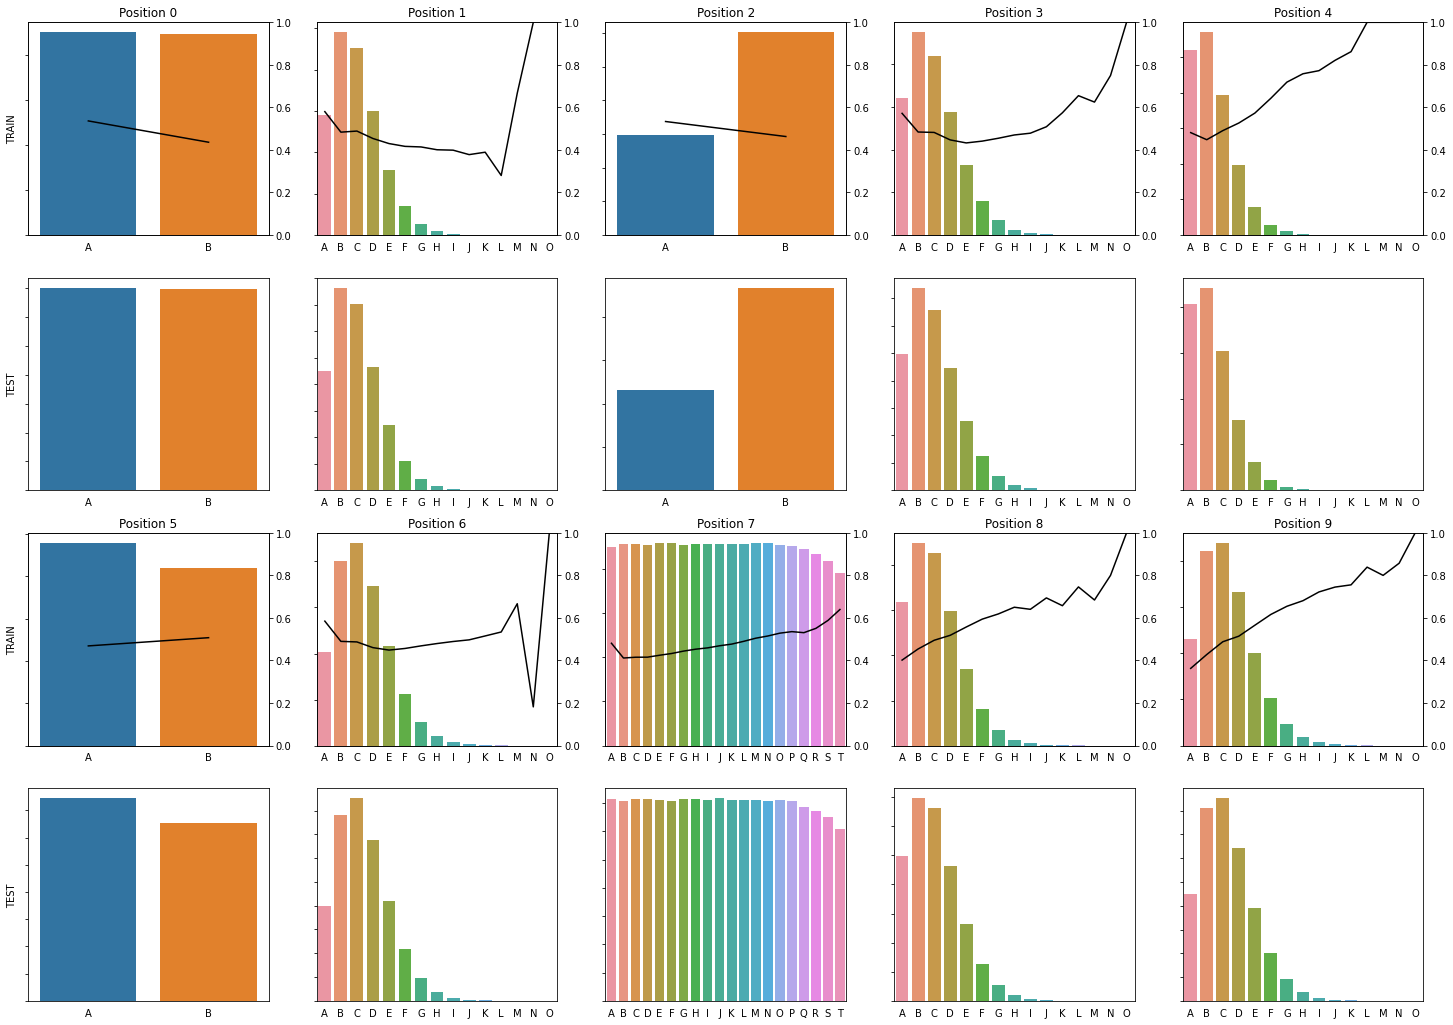

In [7]:
max_letters = {0:'B', # from inspection, the domain of each position is
               1:'O', # 'A' to the letter in this dict.
               2:'B', # Use this for plotting, getting quantiles, etc.
               3:'O',
               4:'O',
               5:'B',
               6:'O',
               7:'T',
               8:'O',
               9:'O'}
plt.figure(figsize=(25,18))

both_counts = []
for i in range(10):
        
    plt.subplot(4,5,i%5 + 10*(i//5) + 1)
    
    letter_freqs_i = pd.DataFrame(cps[i].items())
    letter_freqs_i.index=letter_freqs_i[0]
    letter_freqs_i=letter_freqs_i.reindex([chr(x) for x in it.takewhile(lambda x: chr(x) <= max_letters[i],
                                                         it.count(ord('A')))],
                           fill_value=0)
    letter_freqs_i.columns = ['letter', 'count']
    letter_freqs_i['letter'] = letter_freqs_i.index
    
    ax=sns.barplot(data=letter_freqs_i.sort_values(by=['letter']), x='letter', y='count')
    ax.set_xlabel('')
    ax.set_ylabel('')
    if i % 5 == 0:
        ax.set_ylabel('TRAIN')
    else:
        ax.set_ylabel('')

    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_label('')
   
    ax.set_yticklabels('')
    xs = ax.get_xlim()

    plt.subplot(4,5,i%5 + 10*(i//5)+5 + 1)
    tletter_freqs_i = pd.DataFrame(cps_test[i].items())
    tletter_freqs_i.index=tletter_freqs_i[0]
    tletter_freqs_i=tletter_freqs_i.reindex([chr(x) for x in it.takewhile(lambda x: chr(x) <= max_letters[i],
                                                          it.count(ord('A')))],
                           fill_value=0)
    tletter_freqs_i.columns = ['letter', 'count']
    tletter_freqs_i['letter'] = tletter_freqs_i.index


    axt=sns.barplot(data=tletter_freqs_i.sort_values(by=['letter']), x='letter', y='count')
    axt.set_xlabel('')
    axt.set_ylabel('')
    if i % 5 == 0:
        axt.set_ylabel('TEST')
    else:
        axt.set_ylabel('')

    axt.xaxis.set_ticks_position('none') 
    axt.yaxis.set_label('')

    axt.set_yticklabels('')


    
    f_27_pi = train['f_27'].map(lambda x: ord(x[i])-65)
    tf_27_pi = test['f_27'].map(lambda x: ord(x[i])-65)
    
    Af_27_pi = train['f_27'].map(lambda x: x[i])
    tAf_27_pi = test['f_27'].map(lambda x: x[i])

    lab = f'Af_{i}'
    train[lab] = Af_27_pi

    v = train.groupby(lab)['target'].mean()
    
    target_value = pd.DataFrame({'letter':v.index, 'target':v})
    
    ax2 = ax.twinx()
    sns.lineplot(data = target_value, x='letter', y='target', color='black')

    ax2.set_title(f'Position {i:d}')
    ax2.set_xlim(xs)
    ax2.set_ylim([0,1])
    ax2.set_ylabel('')
    
    both = letter_freqs_i.copy()
    both = letter_freqs_i.merge(tletter_freqs_i, on='letter')
    both['count_both'] = both['count_x'] + both['count_y']
    both['pr_both'] = both['count_both'] / N
    
    both_counts.append(both)


A number of features are evident from this figure:

- The letters in positions  0, 2 and 5 only take the values 'A' and 'B'. Positions zero and five are mostly evenly split between 'A' and 'B', position three is more likely to take value 'B'
- Positions 1, 3, 4, 6, 8 and 9 have gamma-like distributions for letters between 'A' and 'O'.
- Position 7 has nearly uniform distribution for letters between 'A' and 'T', with a slight drop off after 'O'.
- The distribution of letters in the training and test datasets are almost identical for each position

The average value of the target for different letters is also plotted for the training dataset. The binary letter positions (0, 2 and 5) contain only a little independent information about the target For the other positions, it looks like the value of the target is larger for rarer letters, which is mostly later letters in the alphabet, but also 'A', which occurs less frequently than 'B' in most cases.

Next we explore the relationship between the occurrence of letters in different positions. To do this, plot the frequency of letter occurrence for different positions (example here for position 6 vs. position 3). Also to identify the statistical association (correlation) between the occurrence of letters in two different positions, calculate [Cramer's V statistic](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V). 

Association statistic from Cramer's V test: V = 0.03


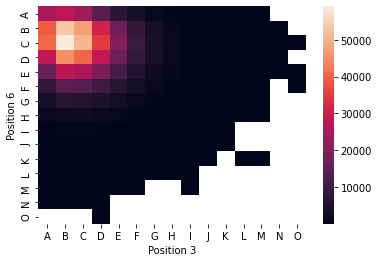

In [8]:
from scipy.stats.contingency import association

Af_ij = train['f_27'].map(lambda x:x[6]).to_frame().merge(train['f_27'].map(lambda x:x[3]).to_frame(), left_index=True, right_index=True)

cc_ij = pd.pivot_table(Af_ij, 
               index='f_27_x',
               columns='f_27_y',
               aggfunc=len)
ax=sns.heatmap(cc_ij)
ax.set_ylabel('Position 6')
ax.set_xlabel('Position 3')

tz = [[0 if np.isnan(y) else int(y) for y in x] for x in np.array(cc_ij)]
print(f"Association statistic from Cramer's V test: V = {association(tz):.2f}")

The heatmap shows nothing special here, with a large peak at the two most common values ('B' for position 3 and 'C' for position 6). The V statistic (think of it like a R2 value) is pretty low (almost zero), indicating that the occurrence of letters at these two positions are definitely independent. Let's now reproduce the same graph for all pairs of letter positions:

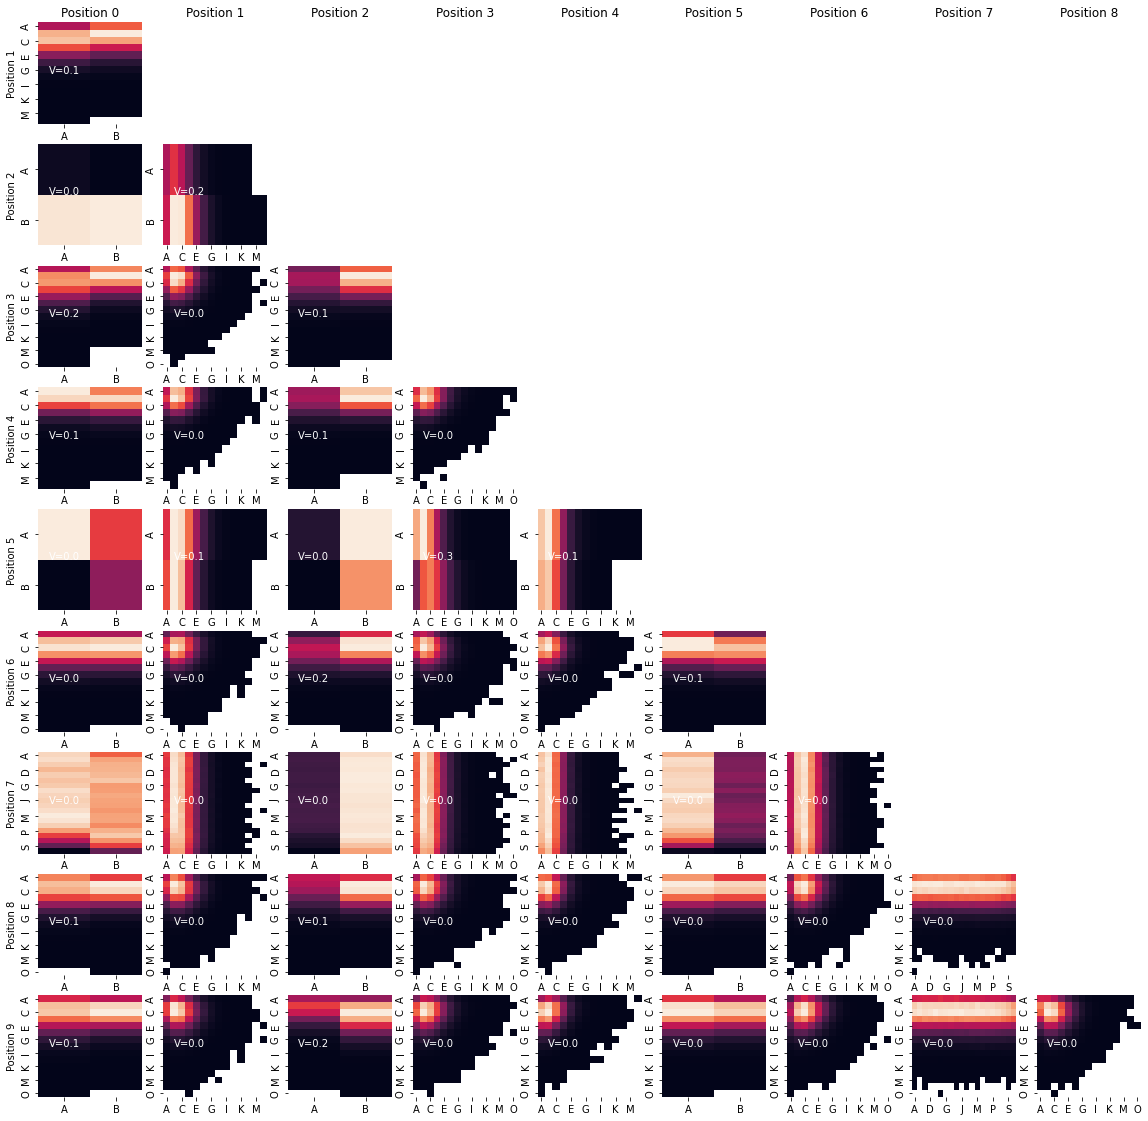

In [9]:

Af_27_pr = []
for i in range(10):
    Af_27_pi = train['f_27'].map(lambda x: x[i]).to_frame()
    Af_27_pr.append(Af_27_pi)
plt.figure(figsize=(22,22))
panelno = 0
for i in range(10):
    for j in range(10):
        panelno += 1
        if i<=j:
            if i == 1 and j < 9:
                ax = plt.subplot(10,10,panelno)
                #dir(ax)
                #ax.option('off')
                ax.axis('off')
                ax.set_title('Position ' + str(j))
            continue
                
        Af_ij = Af_27_pr[i].merge(Af_27_pr[j], left_index=True, right_index=True)
        plt.subplot(10,10,panelno)
        cc_ij = pd.pivot_table(Af_ij, 
               index='f_27_x',
               columns='f_27_y',
               aggfunc=len)
        ax=sns.heatmap(cc_ij, cbar=False)
        tz = [[0 if np.isnan(y) else int(y) for y in x] for x in np.array(cc_ij)]
        #print(association(tz))
        ax.text(0.1,0.5,f'V={association(tz):.1f}',
               transform = ax.transAxes,color='white')
        if j == 0:
            ax.set_ylabel('Position ' + str(i))    
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
        if panelno == 11:
            ax.set_title('Position 0')

The figure show little relations between letter occurrences in different positions. A few pairs (e.g. most notably position 3 and position 5) have a small relationship between letter occurrences with '
'B' occurring in position 5 more likely to occur with later letters in position 3 than 'A' occurring in position 5.

# Summary

- `f_27` is a different feature to all the others, being a string of 10 letters.
- Positions 0, 2 and 5 take either 'A' or 'B'
- Position 6 has a near-uniform distribution of letters from 'A' to 'T'
- All other positions have a skewed distribution of letters with most common letter either 'B' or 'C'. The occurrences could be modelled as a Gamma distribution
- There is little difference between letter distributions in the training and test datasets
- In general, the occurrence of less common letters is associated with a higher value of the target value
- There is little relationship between letter occurrences in different positions, with distribution of letter occurrences more or less independent

I'm not really sure what this feature is meant to represent, but hopefully this analysis is useful as an EDA. Don't forget to upvote if you find it useful! Thanks.